# The "Monolith" Denoising Quantum Autoencoder for Time Series
*TS QAE in PennyLane with angle encoding of TS sliding windows*

**By:** Jacob Cybulski and AInterns<br>
**Date:** August 2023 - November 2025<br>
**Aims:**
- The goal of this notebook is to build a Time Series Quantum Autoencoder.
- This particular notebook aims to build and test a pure PennyLane QAE.
- This *fast* QAE relies on PennyLane 'lightning.qubit' with 'adjoint' diff method.
- The QAE training also features learning rate with decay and mini-batch processing.
- Experiment with relationships between data encoding/decoding and QAE architecture.

**Notes:**
- Refer to a separate "versions" notebook for the log of changes

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/dev',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages/setuptools/_vendor',
 '.',
 '..']

In [3]:
import matplotlib.pyplot as plt
import pylab
import math
import copy
import os.path as path
import time
import warnings

import pennylane as qml
import torch
from pennylane import numpy as np

from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from qae_utils.Tools import draw_circuit
from qae_utils.Charts import plot_hist, meas_plot, multi_plot_flat_ts
from qae_utils.Files import create_folder_if_needed, write_json_file, write_ts_file
from qae_utils.Window import ts_add_noise, ts_wind_make, ts_wind_split, ts_wind_flatten_avg

%matplotlib inline

## Load dataset hyper-parameters

In [4]:
### Debug control
#   Switch to false to remove testing
debug = True

In [5]:
### Set the version of this notebook
major_version = 6
minor_version = 0

In [6]:
### Data settings

# Window settings
# - Intentionally selected as difficult
# - it means with step > 1
wind_size = 6
wind_step = 2
horizon = 1
noise = 0.2
split = 0.75

# Mackey-Glass data 
beta=0.17     # Larger beta = stronger oscillations
gamma=0.1     # Keeps damping moderate
n=10          # Standard nonlinearity
tau=30        # Introduces chaos (try 17–30 for interesting behavior)
x0=1.2        # Initial condition
length=1200   # Length of the generated series (to be shrunk to 200)
data_low = 0  # Range of data
data_high = 1 #

### Random seed(s)
seed = 2025

In [7]:
### Model and training setting
np.random.seed(seed)

# Simulator settings
sim = 'lightning.qubit' # 'default.qubit' # 
interface = 'autograd' # 'torch' # 
diff_method = 'adjoint' # 'parameter-shift' # 
level='gradient'
shots = None

### Model params
rot = 'Rxyz' # Ry / Rxyz
n_layers = 4
n_latent = 4
n_extra = 0

### Derived params
n_trash = wind_size - n_latent
n_data = n_latent + n_trash
n_wires = n_latent + 2*n_trash + 2*n_extra

### Training params
n_epochs = 300
lr_initial = 0.1
lr_decay_rate = 0.75
lr_decay_steps = 60
log_interv = 1
weight_scaler = 0.1
batch_size = 10

# Data encoding setting
# - X is relevant to plotting only
# - Only y are used in windows
X_from = 0
X_to =   2*np.pi

# We need encoding and decoding ranges
y_margin = 0.0
y_enc_low, y_enc_high =  0+y_margin, np.pi/4-y_margin
y_dec_low, y_dec_high =  0+y_margin, np.pi/4-y_margin

# Should noise be clipped or not
noise_clip = True

### Utilities

In [8]:
### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Gets all pytorch parameters
def get_param_vals(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    params = params.cpu().detach().flatten() # [0]
    return params.numpy()

### Creates a completely random seed
def rand_seed():
    t=time.time(); t = int((t-int(t))*10000)
    return t

In [9]:
### Define a type alias for better readability, anticipating NumPy or PennyLane tensor
from typing import Union, Any
Array = Union[np.ndarray, Any] 

### Changes range of x from (low_x, high_x) to (low_y, high_y) 
def x2y(x: Array, xlim = (0, 1), ylim = (0, np.pi)) -> Array:
    """
    x2y(x) = low_y + (x - low_x) * ((high_y - low_y) / (high_x - low_x))
    """
    # Find range limits
    low_x, high_x = xlim
    low_y, high_y = ylim
    
    # Check for a zero-length input range (prevents division by zero)
    input_range_length = high_x - low_x
    if np.isclose(input_range_length, 0.0):
        # If the input range is a single point, map all values to the midpoint of the target range
        print('*** Warning: Input range [low_x, high_x] has zero length. Returning target midpoint.')
        return (low_y + high_y) / 2
    
    # Calculate the scaling factor (ratio of output range length to input range length)
    scaling_factor = (high_y - low_y) / input_range_length
    
    # Apply the linear transformation element-wise:
    #    y = y_min + (x - x_min) * scaling_factor
    y = low_y + (x - low_x) * scaling_factor
    
    return y

# <font color="blue">Data preparation</font>

## <font color="red">Mackie-Glass dataset</font>

In [10]:
### Simulates the Mackey-Glass time series
def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float)
    x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]
        xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

# Generate the Mackey-Glass time series
data_y = mackey_glass(length=length, beta=beta, gamma=gamma, n=n, tau=tau, x0=x0)
data_y = x2y(data_y, xlim=(np.min(data_y), np.max(data_y)), ylim=(data_low, data_high))
data_y = data_y[3::6] # reduce the number of points but keep the shape
data_X = np.array([i for i in range(len(data_y))]) # Number points

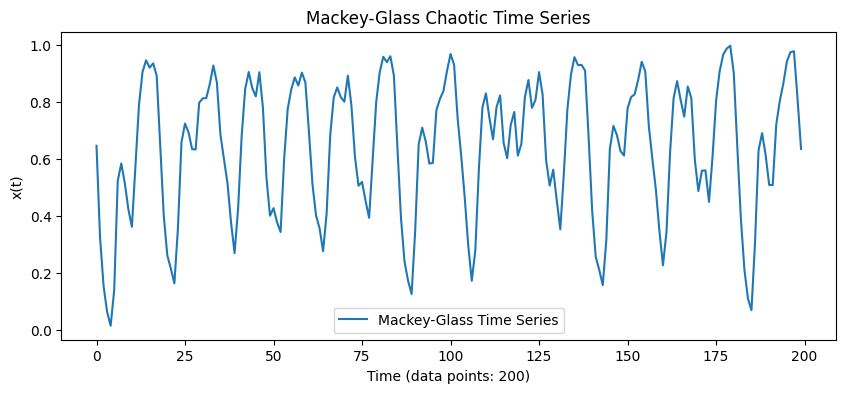

In [11]:
### Plot the Mackey-Glass time series
plt.figure(figsize=(10, 4))
plt.plot(data_y, label='Mackey-Glass Time Series')
plt.xlabel(f'Time (data points: {len(data_X)})')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare data for training

In [12]:
### Makes mini-batches of time series windows
#   Yields: a mini-batch.
def get_mini_batches(W_noisy, W_clean, batch_size=10, shuffle=True, seed=0):
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    num_samples = W_clean.shape[0]
    indices = np.arange(num_samples)
    if shuffle: np.random.shuffle(indices)

    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        yield W_noisy[batch_indices], W_clean[batch_indices]

In [13]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, range_low=0.2, range_high=0.8, 
                   seed=0, noise_clip=True):
    y_noisy = ts_add_noise(y, noise=noise, noise_type='normal', clip=noise_clip,
        range_low=range_low, range_high=range_high, seed=seed)
    y_ts = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = ts_wind_make(X, wind_size, wind_step)
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [14]:
from pprint import pprint

### Prepare data for encoding
y = x2y(data_y, xlim=(data_low, data_high), ylim=(y_enc_low, y_enc_high))
X = x2y(data_X, xlim=(np.min(data_X), np.max(data_X)), ylim=(X_from, X_to)) # Keep the original coords

### Create windows and split into training and test partitions
X_train_coords, y_train_coords, X_test_coords, y_test_coords = \
        create_sw_tens(X, X, noise=0.0, wind_size=wind_size, wind_step=wind_step, 
                       range_low=y_enc_low, range_high=y_enc_high, seed=seed)
X_train_tens, y_train_tens, X_test_tens, y_test_tens = \
    create_sw_tens(y, y, noise=0.0, wind_size=wind_size, wind_step=wind_step, 
                   range_low=y_enc_low, range_high=y_enc_high, seed=seed)
_, X_train_noisy_tens, _, X_test_noisy_tens = \
    create_sw_tens(y, y, noise=noise, wind_size=wind_size, wind_step=wind_step, 
                   range_low=y_enc_low, range_high=y_enc_high, seed=seed, noise_clip=noise_clip)

### Find partition sizes
n_samples = len(y)
n_train = len(X_train_tens)
n_test = len(X_test_tens)

### Print a sample of data
print('\nSample of training partition:\n\nWindow coordinates:')
pprint(X_train_coords[0:3])
print('\nWindow values:')
pprint(X_train_tens[0:3]); 
print('\nSample of test partition:\n\nWindow coordinates:')
pprint(X_test_coords[0:3])
print('\nWindow values:')
pprint(X_test_tens[0:3]); print()


Sample of training partition:

Window coordinates:
tensor([[0.        , 0.0315738 , 0.06314759, 0.09472139, 0.12629518,
         0.15786898],
        [0.06314759, 0.09472139, 0.12629518, 0.15786898, 0.18944277,
         0.22101657],
        [0.12629518, 0.15786898, 0.18944277, 0.22101657, 0.25259036,
         0.28416416]], requires_grad=False)

Window values:
tensor([[0.50815341, 0.2553533 , 0.12100495, 0.04960673, 0.01166279,
         0.11026403],
        [0.12100495, 0.04960673, 0.01166279, 0.11026403, 0.4115649 ,
         0.45933812],
        [0.01166279, 0.11026403, 0.4115649 , 0.45933812, 0.40463055,
         0.33259536]], requires_grad=False)

Sample of test partition:

Window coordinates:
tensor([[4.67292174, 4.70449553, 4.73606933, 4.76764312, 4.79921692,
         4.83079071],
        [4.73606933, 4.76764312, 4.79921692, 4.83079071, 4.86236451,
         4.8939383 ],
        [4.79921692, 4.83079071, 4.86236451, 4.8939383 , 4.9255121 ,
         4.9570859 ]], requires_grad=False)

### Plot flattened windows with sample noise
- Noise was clipped not to exceed the range [0..pi]

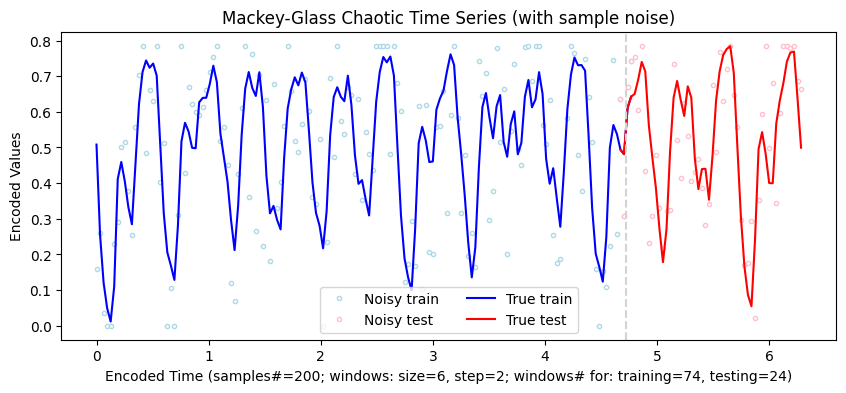

In [15]:
### Flatten windows by averaging overlapping data
X_train_flat_ts = ts_wind_flatten_avg(X_train_tens, wind_step)
X_test_flat_ts = ts_wind_flatten_avg(X_test_tens, wind_step)
X_train_noisy_flat_ts = ts_wind_flatten_avg(X_train_noisy_tens, wind_step)
X_test_noisy_flat_ts = ts_wind_flatten_avg(X_test_noisy_tens, wind_step)
X_train_flat_coords = ts_wind_flatten_avg(X_train_coords, wind_step)
X_test_flat_coords = ts_wind_flatten_avg(X_test_coords, wind_step)

# Plot partitions
plt.figure(figsize=(10, 4))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, label="Noisy train", color="lightblue", linestyle='', mfc='white', marker='.')
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, label="Noisy test", color="pink", linestyle='', mfc='white', marker='.')
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="blue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="red")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='--')
plt.xlabel(f'Encoded Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('Encoded Values')
plt.title('Mackey-Glass Chaotic Time Series (with sample noise)')
plt.legend(loc='best', ncol=2)
plt.show()

# <font color="blue">Models building</font>

### Cost functions

In [16]:
### Our own gradient-friendly loss/cost function
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

### The cost function generator
def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, cost_fun
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

## <font color="red">Monolith model</font>
*Note that the trainnig model will be used further, however, the testing model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

### Model creation

In [17]:
### Estimates the shape of the "half_qae_enc_with_swap"
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def full_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    return shape

In [18]:
### Full-QAE Circuit: Input + Encoder + Decoder + Output + No Swap Test
#   wires: list/array of wires to create a full QAE
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_extra: number of additional qubits to increase circuit breadth
#   n_layers: number of layers (repeats)
#   rot: rotation type, 'Ry' or 'Rxyz'
#   add_outseq: if True, the inverse of the input sequence will be added on output
#     If so, data needs to be split into input and output sequence
#   invert_dec: If True the decoder ansatz will be inverted
#   returns: QAE building function which takes arguments
#     inputs: list/array of input values to be angle encoded
#     weights: list/array of weights shaped to be used in ansatz blocks

def full_qae(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Ry', add_outseq=True, invert_dec=True):

    n_data = n_latent + n_trash
    n_anz = n_data + n_extra
    n_zero = n_trash + n_extra
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    extra_wires = wires[n_data:n_data+n_extra]
    zero_wires = wires[n_anz:n_anz+n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires + extra_wires

    ### Encodes a sequence on in put (similar to AngleEncoding)
    def _sequence_encoder(wires, inputs):
        qml.AngleEmbedding(inputs, wires=wires, rotation='Y')

    ### Entangler shape
    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()

    ### Entangler
    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    def _swap(from_wires, to_wires):
        for i in range(len(from_wires)):
            qml.SWAP(wires=[from_wires[i], to_wires[i]])

    ### Full QAE encoder
    def _full_qae(weights, inputs):
        
        nonlocal wires, n_latent, n_trash, n_extra, n_layers, rot
        nonlocal latent_wires, trash_wires, extra_wires, data_wires, anz_wires
        nonlocal add_outseq, invert_dec, zero_wires
                
        n_anz_wires = n_latent + n_trash + n_extra 
        n_data = n_latent + n_trash
    
        # Add input encoder
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)
    
        # Find encoder/decoder shapes
        #    This function assumes symmetric QAE so they are identical
        enc_weights_shape = _entangler_shape(n_layers, n_anz_wires, rot=rot)
        dec_weights_shape = enc_weights_shape
     
        # Split and shape weights for encoder and decoder ansatze
        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        # Add encoder ansatz
        _entangler(anz_wires, enc_weights, rot=rot)        
      
        # Add initialisation of trash and extra space
        qml.Barrier(wires)
        _swap(trash_wires+extra_wires, zero_wires)
        qml.Barrier(wires)
    
        # Add decoder ansatz
        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        else:
            _entangler(anz_wires, enc_weights, rot=rot)
        qml.Barrier(wires)
    
        # Add output sequence if needed
        if add_outseq:
            qml.adjoint(_sequence_encoder)(data_wires, inputs)
            
        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]
    return _full_qae

In [19]:
if debug:
    test_latent = 3; test_trash = 2; test_extra = 1; test_layers=2
    test_inputs = test_latent + test_trash
    test_wires = test_latent + 2*test_trash + 2*test_extra
    test_wires = list(range(test_wires))
    test_rot = 'Ry'
    
    test_shape = full_qae_shape(test_latent, test_trash, test_extra, n_layers=test_layers, rot=test_rot)
    test_n_weights = np.prod(test_shape)
    print(f'Full-QAE shape: {test_shape}, weights: {int(test_n_weights)}\n')
    
    test_data = np.linspace(100, 200, test_inputs, requires_grad=False)
    test_weights = np.random.rand(*test_shape, requires_grad=True)
    
    print(f'Data ({test_data.shape}): \n{test_data}\n')
    print(f'Weights ({test_weights.shape}): \n{test_weights}\n')

Full-QAE shape: (4, 6), weights: 24

Data ((5,)): 
[100. 125. 150. 175. 200.]

Weights ((4, 6)): 
[[0.13548816 0.8878517  0.93260564 0.44556816 0.38823555 0.25759644]
 [0.65736759 0.49261694 0.96423842 0.80098447 0.45520529 0.80105809]
 [0.04171797 0.76945787 0.00317112 0.29280939 0.61091433 0.91302739]
 [0.300115   0.24859864 0.6663921  0.98753291 0.46827041 0.12328738]]



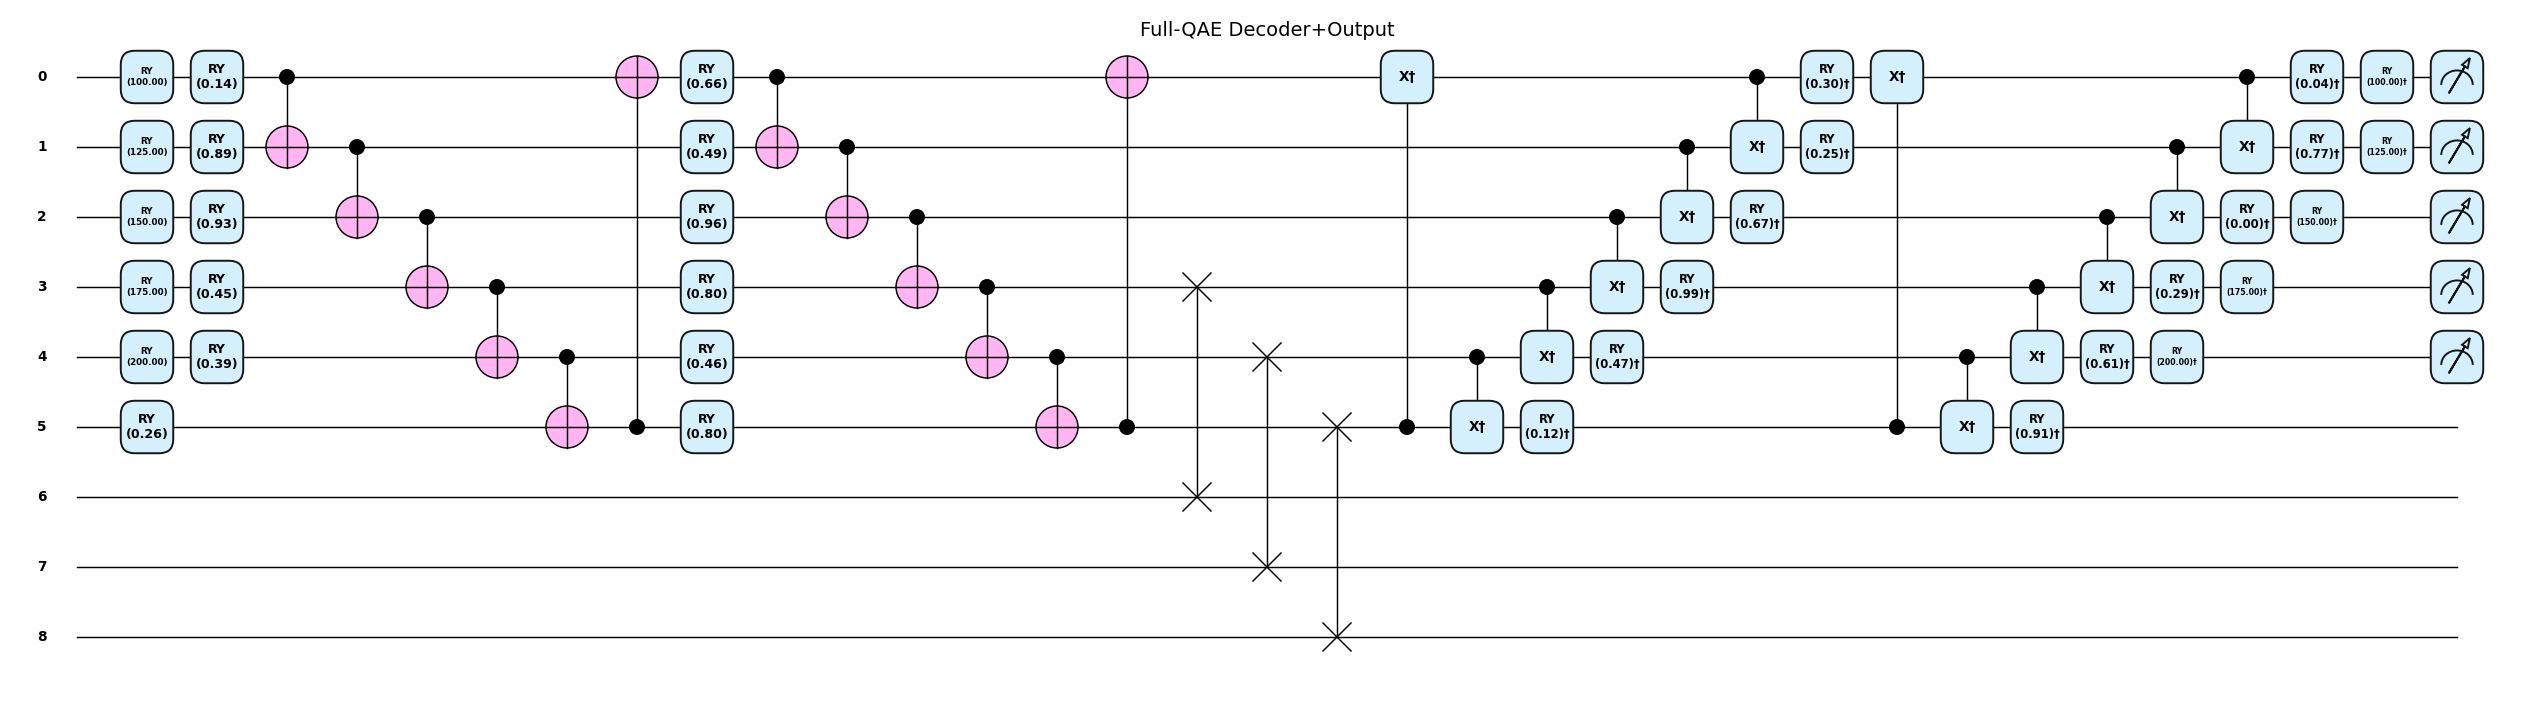

In [20]:
if debug:
    ### Testing full-QAE for training
    
    # Define a static full-QAE
    test_qae = full_qae(test_wires, test_latent, test_trash, test_extra, n_layers=test_layers, rot=test_rot, add_outseq=True, invert_dec=True)
    
    # Create and draw a full-QAE
    test_dev = qml.device(sim, wires=test_wires, shots=shots)
    test_qae_qc = qml.QNode(test_qae, test_dev, interface=interface, diff_method=diff_method)
    draw_circuit(test_qae_qc, scale=0.7, title='Full-QAE Decoder+Output', level='device') \
        (test_weights, test_data) # expansion_strategy='device'/'gradient'

## Create and train the model
Test the model with sample parameters and data

In [21]:
##### Training loop

def train_with_noise(model, W, cost_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, enc_lim=(0, 1), dec_lim=(0, 1)):

    ### Find encoding and decoding limits
    enc_low, enc_high = enc_lim
    dec_low, dec_high = dec_lim
    
    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure, _, _ = create_sw_tens(W, W, noise=0, 
        wind_size=wind_size, wind_step=wind_step, range_low=enc_low, range_high=enc_high)
    
    ### Rescale targets to expvals [1..-1]
    y_pure = x2y(y_pure, xlim=(enc_low, enc_high), ylim=(dec_low, dec_high))
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy, _, _ = create_sw_tens(W, W, noise=noise, seed=seed+iter, noise_clip=noise_clip,
            wind_size=wind_size, wind_step=wind_step, range_low=enc_low, range_high=enc_high)
    
        # Decay learning rate
        if (iter+1) % lr_decay_steps == 0: 
            optimizer.stepsize *= lr_decay_rate

        # Train the model in mini-batches
        batches = get_mini_batches(X_noisy, y_pure, batch_size=batch_size, shuffle=True, seed=seed+iter)
        acc_batch_cost = 0
        for batch_no, (noisy_batch, pure_batch) in enumerate(batches):
            params, batch_cost = optimizer.step_and_cost(lambda p: cost_fun(p, noisy_batch, pure_batch), params)
            acc_batch_cost += batch_cost
        cost = acc_batch_cost / (batch_no+1)

        # End of epoch processing
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):04d} sec) cost={cost:0.6f} '+\
                  f'(opt LR={optimizer.stepsize:0.4f})')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

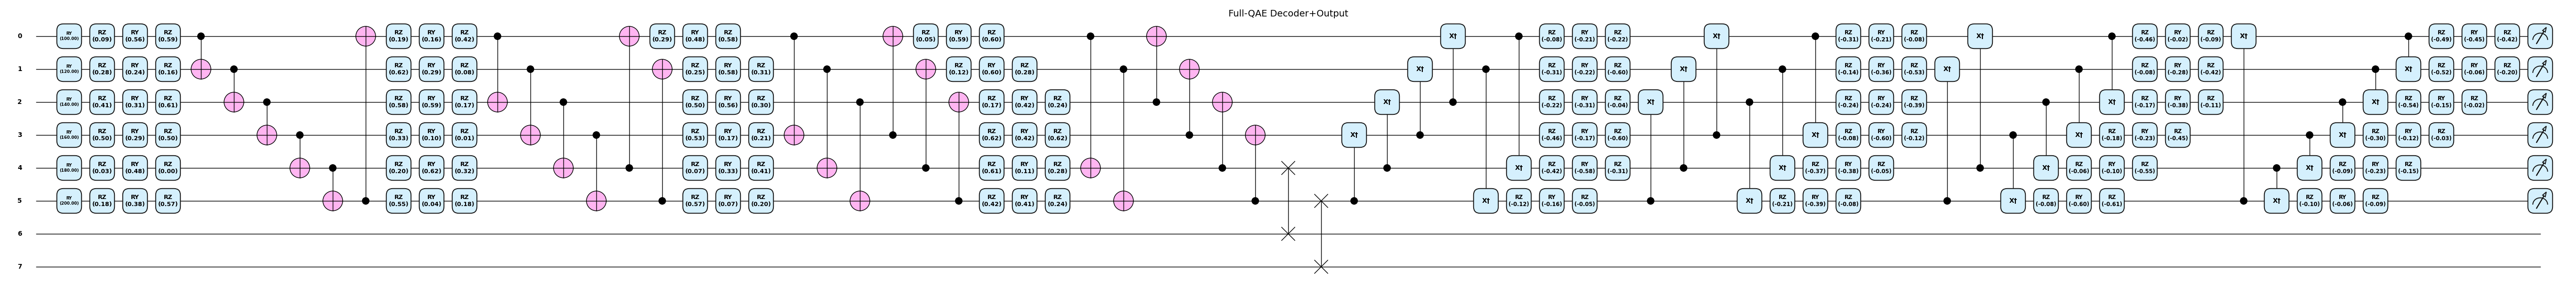

Full-QAE shape: (8, 6, 3), weights: 144



In [22]:
##### Create a model

### For reproducibility
np.random.seed(seed)

### Check the QAE shape
wires = list(range(n_wires))
shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)

### Initialise weights
init_weights = np.random.uniform(high=2*np.pi, size=shape, requires_grad=True)*weight_scaler

### Create a model
qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=False, invert_dec=True)

# Create and draw a sample-QAE
dev = qml.device(sim, wires=n_wires, shots=shots, seed=seed)
qae_model = qml.QNode(qae, dev, interface=interface, diff_method=diff_method)
sample_data = np.linspace(100, 200, n_data, requires_grad=False)
draw_circuit(qae_model, scale=0.7, title='Full-QAE Decoder+Output', level='device') \
    (init_weights, sample_data) # expansion_strategy='device'/'gradient'
print(f'Full-QAE shape: {shape}, weights: {int(n_weights)}\n')

In [23]:
### Test I/O for the QAE
if debug:
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, seed=seed,
        wind_size=wind_size, wind_step=wind_step, range_low=y_enc_low, range_high=y_enc_high)
    _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, seed=seed, noise_clip=noise_clip,
        wind_size=wind_size, wind_step=wind_step, range_low=y_enc_low, range_high=y_enc_high)
    X_noisy_tens = x2y(X_noisy_tens, xlim=(y_enc_low, y_enc_high), ylim=(y_dec_low, y_dec_high))
    results_pure_tens = np.array([qae_model(init_weights, x) for x in X_noisy_tens])
    pred_pure_tens = np.stack(results_pure_tens)
    print(f'X noisy={X_noisy_tens.shape}: \n{X_noisy_tens[0:3]}\n')
    print(f'y pure=({y_pure_tens.shape}[0:3]): \n{y_pure_tens[0:3]}\n')
    print(f'y pred=({pred_pure_tens.shape}[0:3]):\n{pred_pure_tens[0:3]}\n')

X noisy=(74, 6): 
[[0.15923967 0.25943731 0.0363439  0.         0.         0.23049143]
 [0.0363439  0.         0.         0.23049143 0.29223003 0.50127779]
 [0.         0.23049143 0.29223003 0.50127779 0.51486603 0.37848167]]

y pure=((74, 6)[0:3]): 
[[0.50815341 0.2553533  0.12100495 0.04960673 0.01166279 0.11026403]
 [0.12100495 0.04960673 0.01166279 0.11026403 0.4115649  0.45933812]
 [0.01166279 0.11026403 0.4115649  0.45933812 0.40463055 0.33259536]]

y pred=((74, 6)[0:3]):
[[-0.04753906  0.10372461  0.12570875  0.11645577  0.06614585  0.11556329]
 [-0.06211294  0.12088325  0.05537681  0.07214424  0.09620927  0.06702102]
 [-0.06870463  0.07514509  0.02561429  0.08571619  0.04630178 -0.0218094 ]]



### Training run

In [24]:
##### Prepare for training

### For reproducibility
np.random.seed(seed)

### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)
opt = qml.AdamOptimizer(stepsize=lr_initial, beta1=0.99)

### Define the cost function
cost_fun = cost_fun_gen_on_tensors(qae_model, mse_cost_on_tensors)
    
### Training loop
hist_cost, hist_params, init_weights, stats = train_with_noise(
    qae_model, y, cost_fun, opt, n_epochs, init_weights, 
    wind_size=wind_size, wind_step=wind_step, noise=noise, log_interv=log_interv, 
    prompt_fract=0.1, seed=seed, enc_lim=(y_enc_low, y_enc_high), dec_lim=(y_dec_low, y_dec_high))

Iter: 000 (0002 sec) cost=0.105401 (opt LR=0.1000)
Iter: 030 (0068 sec) cost=0.015840 (opt LR=0.1000)
Iter: 060 (0130 sec) cost=0.012168 (opt LR=0.0750)
Iter: 090 (0192 sec) cost=0.014298 (opt LR=0.0750)
Iter: 120 (0254 sec) cost=0.011499 (opt LR=0.0563)
Iter: 150 (0316 sec) cost=0.014806 (opt LR=0.0563)
Iter: 180 (0378 sec) cost=0.008012 (opt LR=0.0422)
Iter: 210 (0439 sec) cost=0.010181 (opt LR=0.0422)
Iter: 240 (0501 sec) cost=0.012098 (opt LR=0.0316)
Iter: 270 (0563 sec) cost=0.012140 (opt LR=0.0316)

Training completed: epochs=300, min cost=0.007234 @ 243, time=623 secs



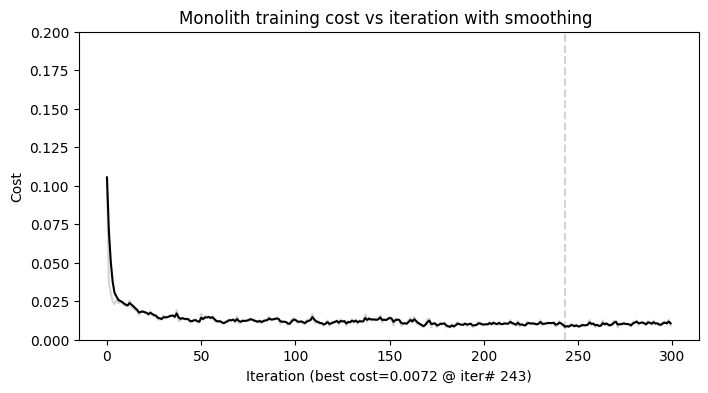

In [25]:
### Plot training cost
#   Note that best model may not have been saved
#   because models are being saved at predefined intervals (log_interv)
meas_plot(hist_cost, meas='cost', task='min', title_pref='Monolith training', ylim=(0, 0.2),
    rcParams=(8, 4), log_interv=1, backplot=True, back_color='lightgray', smooth_weight=0.5)

### Save training history

In [26]:
### Save the current model results info the log 
# from qae_utils.Files import write_pickle_file
# inst = n_inst-1 # There is only one at the moment
# history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/hist.pkl'
# init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/init.pkl'
# params_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/params.pkl'
# write_pickle_file(history_fpath, hist_cost)
# write_pickle_file(init_fpath, init_weights.numpy())
# write_pickle_file(params_fpath, np.stack(hist_params).numpy())

## Test the trained model

### Create test data, pure and with noise
*Test both pure and noisy TSs*

In [27]:
### Add noise to pure data to create a sample noisy data

# Create a sample of pure and noisy training and test tensors
X_train_pure_tens, y_train_pure_tens, X_test_pure_tens, y_test_pure_tens = \
    create_sw_tens(y, y, noise=0, wind_size=wind_size, wind_step=wind_step,
                   range_low=y_enc_low, range_high=y_enc_high)
X_train_noisy_tens, y_train_noisy_tens, X_test_noisy_tens, y_test_noisy_tens = \
    create_sw_tens(y, y, noise=noise, wind_size=wind_size, wind_step=wind_step, 
                   seed=seed+n_epochs, noise_clip=noise_clip, range_low=y_enc_low, range_high=y_enc_high)

### Create a test model based on optimum parameters

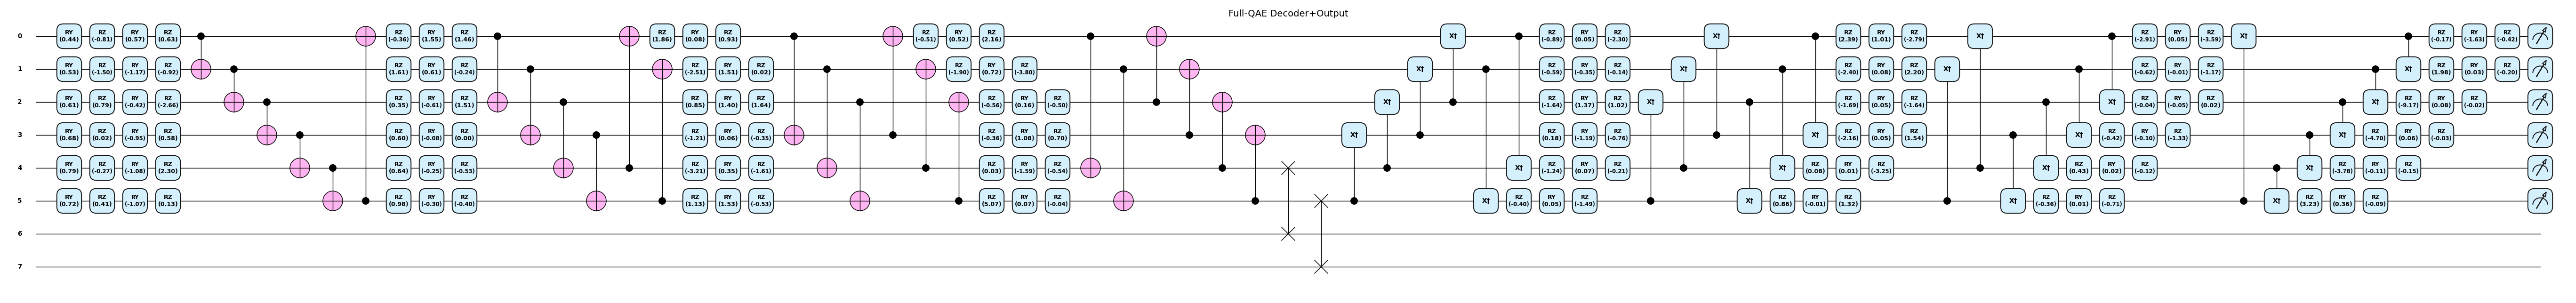

In [28]:
### Create a test model and reconstruct data from noise

opt_params = hist_params[stats[0]]
wires = list(range(n_wires))
test_qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=False, invert_dec=True)
test_qae_model = qml.QNode(test_qae, dev, interface=interface, diff_method=diff_method)
draw_circuit(test_qae_model, scale=0.7, title='Full-QAE Decoder+Output', level='device') \
    (opt_params, y_test_noisy_tens[0]) # expansion_strategy='device'/'gradient'

In [29]:
### Create predictions for pure and noisy data
pred_from_pure_train_tens = np.stack([test_qae_model(opt_params, x) for x in y_train_pure_tens], requires_grad=False)
pred_from_pure_test_tens = np.stack([test_qae_model(opt_params, x) for x in y_test_pure_tens], requires_grad=False)
pred_from_noisy_train_tens = np.stack([test_qae_model(opt_params, x) for x in y_train_noisy_tens], requires_grad=False)
pred_from_noisy_test_tens = np.stack([test_qae_model(opt_params, x) for x in y_test_noisy_tens], requires_grad=False)

In [30]:
### Flatten original TSs for plotting (y -> y)

### Flatten all windows data and coordinates
X_train_flat_coords = ts_wind_flatten_avg(X_train_coords, wind_step)
X_test_flat_coords = ts_wind_flatten_avg(X_test_coords, wind_step)

# Flatten original TSs for plotting, in encoding range. e.g. [0, 1] or [-pi, 0]
y_train_pure_flat = x2y(ts_wind_flatten_avg(y_train_pure_tens, wind_step), xlim=(y_enc_low, y_enc_high), ylim=(data_low, data_high))
y_test_pure_flat = x2y(ts_wind_flatten_avg(y_test_pure_tens, wind_step), xlim=(y_enc_low, y_enc_high), ylim=(data_low, data_high))
y_train_noisy_flat = x2y(ts_wind_flatten_avg(y_train_noisy_tens, wind_step), xlim=(y_enc_low, y_enc_high), ylim=(data_low, data_high))
y_test_noisy_flat = x2y(ts_wind_flatten_avg(y_test_noisy_tens, wind_step), xlim=(y_enc_low, y_enc_high), ylim=(data_low, data_high))

### Flatten recovered TSs, in measurement range, e.g. [-1, 1] or smaller [0, 1]
pred_from_pure_train_flat = x2y(ts_wind_flatten_avg(pred_from_pure_train_tens, wind_step), xlim=(y_dec_low, y_dec_high), ylim=(data_low, data_high))
pred_from_pure_test_flat = x2y(ts_wind_flatten_avg(pred_from_pure_test_tens, wind_step), xlim=(y_dec_low, y_dec_high), ylim=(data_low, data_high))
pred_from_noisy_train_flat = x2y(ts_wind_flatten_avg(pred_from_noisy_train_tens, wind_step), xlim=(y_dec_low, y_dec_high), ylim=(data_low, data_high))
pred_from_noisy_test_flat = x2y(ts_wind_flatten_avg(pred_from_noisy_test_tens, wind_step), xlim=(y_dec_low, y_dec_high), ylim=(data_low, data_high))

In [31]:
### Calculate metrics to show in charts
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse_train_pure_vs_noisy = mean_squared_error(y_train_pure_flat, y_train_noisy_flat)
mse_test_pure_vs_noisy = mean_squared_error(y_test_pure_flat, y_test_noisy_flat)
mse_train_pure_vs_rec_from_pure = mean_squared_error(y_train_pure_flat, pred_from_pure_train_flat)
mse_test_pure_vs_rec_from_pure = mean_squared_error(y_test_pure_flat, pred_from_pure_test_flat)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(y_train_pure_flat, pred_from_noisy_train_flat)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(y_test_pure_flat, pred_from_noisy_test_flat)

In [32]:
print(f'\nMSE train (pure vs noise) ~ (pure vs recovered from pure) =  '+\
      f'{mse_train_pure_vs_noisy:0.6f} ~ {mse_train_pure_vs_rec_from_pure:0.6f} '+\
      f'({-(mse_train_pure_vs_noisy-mse_train_pure_vs_rec_from_pure)/mse_train_pure_vs_noisy*100:+3.2f}%)')
print(f'MSE test  (pure vs noise) ~ (pure vs recovered from pure) =  '+\
      f'{mse_test_pure_vs_noisy:0.6f} ~ {mse_test_pure_vs_rec_from_pure:0.6f} '+\
      f'({-(mse_test_pure_vs_noisy-mse_test_pure_vs_rec_from_pure)/mse_test_pure_vs_noisy*100:+3.2f}%)\n')

print(f'MSE train (pure vs noise) ~ (pure vs recovered from noisy) = '+\
      f'{mse_train_pure_vs_noisy:0.6f} ~ {mse_train_pure_vs_rec_from_noisy:0.6f} '+\
      f'({-(mse_train_pure_vs_noisy-mse_train_pure_vs_rec_from_noisy)/mse_train_pure_vs_noisy*100:+3.2f}%)')
print(f'MSE test  (pure vs noise) ~ (pure vs recovered from noisy) = '+\
      f'{mse_test_pure_vs_noisy:0.6f} ~ {mse_test_pure_vs_rec_from_noisy:0.6f} '+\
      f'({-(mse_test_pure_vs_noisy-mse_test_pure_vs_rec_from_noisy)/mse_test_pure_vs_noisy*100:+3.2f}%)')


MSE train (pure vs noise) ~ (pure vs recovered from pure) =  0.037307 ~ 0.005327 (-85.72%)
MSE test  (pure vs noise) ~ (pure vs recovered from pure) =  0.031411 ~ 0.005376 (-82.88%)

MSE train (pure vs noise) ~ (pure vs recovered from noisy) = 0.037307 ~ 0.015229 (-59.18%)
MSE test  (pure vs noise) ~ (pure vs recovered from noisy) = 0.031411 ~ 0.013843 (-55.93%)


### Plotting of data "recovery" from <font color="red">clean data</font>

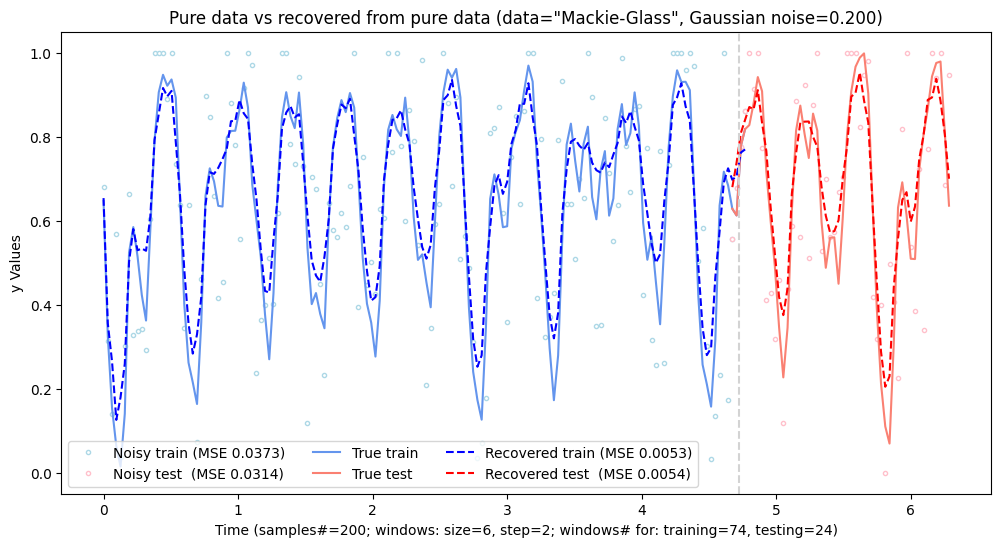

In [33]:
### Plot the original and recovered from pure data with added performance metrics
# exper_from_pure_train_flat = 4*(0.5-pred_from_pure_train_flat)+1
# exper_from_pure_test_flat = 4*(0.5-pred_from_pure_test_flat)+1

# Plot partitions
print()
# Plot partitions
print()
plt.figure(figsize=(12, 6))
plt.plot(X_train_flat_coords, y_train_noisy_flat, color="lightblue", linestyle='', mfc='white', marker='.', 
         label=f"Noisy train (MSE {mse_train_pure_vs_noisy:0.4f})")
plt.plot(X_test_flat_coords, y_test_noisy_flat, color="pink", linestyle='', mfc='white', marker='.', 
         label=f"Noisy test  (MSE {mse_test_pure_vs_noisy:0.4f})")
plt.plot(X_train_flat_coords, y_train_pure_flat, label="True train", color="cornflowerblue")
plt.plot(X_test_flat_coords, y_test_pure_flat, label="True test", color="salmon")
plt.plot(X_train_flat_coords, pred_from_pure_train_flat, color="blue", linestyle='dashed', 
         label=f"Recovered train (MSE {mse_train_pure_vs_rec_from_pure:0.4f})")
plt.plot(X_test_flat_coords, pred_from_pure_test_flat, color="red", linestyle='dashed', 
         label=f"Recovered test  (MSE {mse_test_pure_vs_rec_from_pure:0.4f})")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='dashed')
plt.xlabel(f'Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('y Values')
plt.title(f'Pure data vs recovered from pure data (data="Mackie-Glass", Gaussian noise={noise:0.3f})')
plt.legend(loc='lower left', ncol=3)
# plt.ylim(0, 1)
plt.show()
print()

### Plotting of data recovery from <font color="red">noisy data</font>

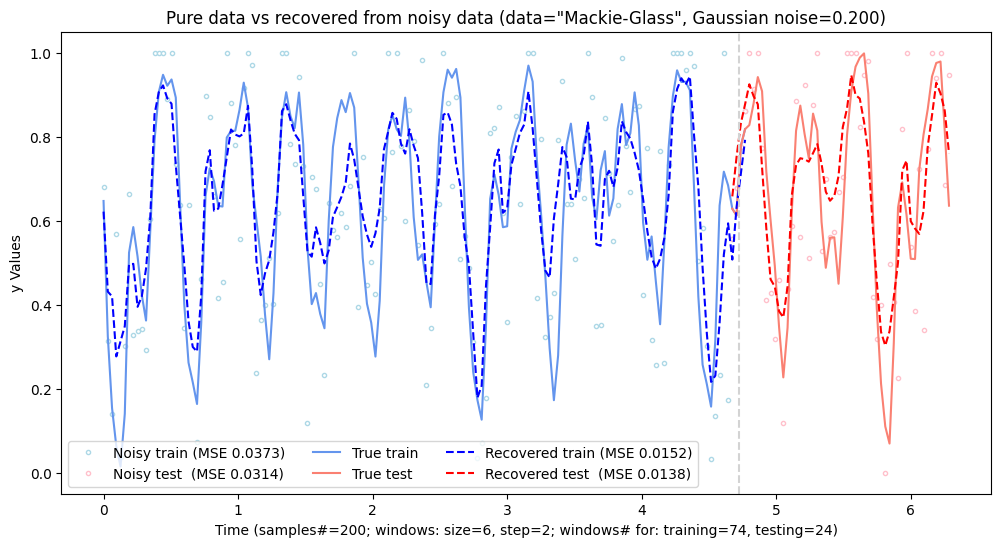

In [34]:
### Plot the original and recovered from noisy data with added performance metrics

# Plot partitions
print()
plt.figure(figsize=(12, 6))
plt.plot(X_train_flat_coords, y_train_noisy_flat, color="lightblue", linestyle='', mfc='white', marker='.', 
         label=f"Noisy train (MSE {mse_train_pure_vs_noisy:0.4f})")
plt.plot(X_test_flat_coords, y_test_noisy_flat, color="pink", linestyle='', mfc='white', marker='.', 
         label=f"Noisy test  (MSE {mse_test_pure_vs_noisy:0.4f})")
plt.plot(X_train_flat_coords, y_train_pure_flat, label="True train", color="cornflowerblue")
plt.plot(X_test_flat_coords, y_test_pure_flat, label="True test", color="salmon")
plt.plot(X_train_flat_coords, pred_from_noisy_train_flat, color="blue", linestyle='dashed', 
         label=f"Recovered train (MSE {mse_train_pure_vs_rec_from_noisy:0.4f})")
plt.plot(X_test_flat_coords, pred_from_noisy_test_flat, color="red", linestyle='dashed', 
         label=f"Recovered test  (MSE {mse_test_pure_vs_rec_from_noisy:0.4f})")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='dashed')
plt.xlabel(f'Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('y Values')
plt.title(f'Pure data vs recovered from noisy data (data="Mackie-Glass", Gaussian noise={noise:0.3f})')
plt.legend(loc='lower left', ncol=3)
# plt.ylim(0, 1)
plt.show()
print()

## References

**Academic**
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.
2. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

**Practice**
1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder
2. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test
3. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.
4. Ali Shannon, "techshot25/Autoencoders", accessed March 12, 2024, https://github.com/techshot25/Autoencoders.
5. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
6. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.

# Software in use

In [35]:
!pip list | grep -E 'PennyLane|torch|jax'

PennyLane                     0.41.1
PennyLane_Lightning           0.41.1
torch                         2.7.0
torchaudio                    2.7.0
torchsummary                  1.5.1
torchvision                   0.22.0
